In [80]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

### TODO
Add CUDA

In [82]:
N_SAMPLES = 500
NOISE_STD = .5

In [83]:
def gen_data(n_samples, ordered=False):
    
    if ordered:
        x = np.linspace(-15, 15, n_samples)
        
    else:
        x = np.linspace(-15, 15, n_samples) #np.random.uniform(-15, 15, n_samples)
    
    y = x**3/10 + np.sin(x)*50
    
    return x.reshape(-1, 1), y.reshape(-1, 1)

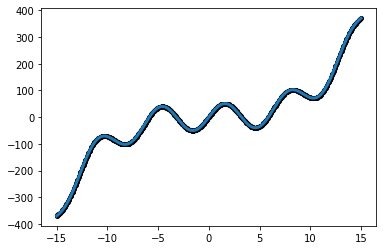

In [84]:
x = np.linspace(-15, 15, N_SAMPLES)
y = x**3/10 + np.sin(x)*50

plt.plot(x, y, linewidth=3)
plt.scatter(x, y, color='black', s=16)

In [85]:
class GenericDataset(Dataset):
    
    def __init__(self, n_batches, noise_std):
        super().__init__()
        
        self.n_batches = n_batches
        self.noise_std = noise_std
        
    def __len__(self):
        return self.n_batches
    
    def __getitem__(self, idx):
        
        context_x, context_y = gen_data(5)
        context_y = context_y + np.random.normal(0, self.noise_std, context_y.shape)
        
        target_x, target_y = gen_data(5)
        target_y = target_y + np.random.normal(0, self.noise_std, context_y.shape)
        
        return context_x, context_y, target_x, target_y

In [86]:
train_dataset = GenericDataset(100, NOISE_STD)
train_dataloader = DataLoader(train_dataset, batch_size = 32)

In [87]:
class AttentionHead(torch.nn.Module):
    """Attention head as given in https://arxiv.org/abs/1706.03762.
    
    In brief, the queries, keys and values (Q, K, V) are projected into
    user-defined dimensions and then passed through dot-product attention.
    """
    
    def __init__(self, input_dims_Q, input_dims_K, input_dims_V, dim_k, dim_v):
        super().__init__()
        """Class constructor.
        
        Arguments
        ---------
        input_dims_Q: int
            Dimensions in raw queries before being projected to dim_k.
        input_dims_K: int
            Dimensions in raw keys before being projected to dim_k.
        input_dims_V: int
            Dimensions in raw values before being projected to dim_v.
        dim_k: int
            Dimensions to project raw queries and keys to.
        dim_v: int
            Dimensions to project raw values to.
        """
        
        self.dim_k = dim_k
        self.dim_v = dim_v
        
        self.project_Q = torch.nn.Linear(input_dims_Q, dim_k)
        self.project_K = torch.nn.Linear(input_dims_K, dim_k)
        self.project_V = torch.nn.Linear(input_dims_V, dim_v)
        
    def dot_product_attention(self, Q, K, V):
        """Dot product attention as given in https://arxiv.org/abs/1706.03762, where
        Q, K and V are the queries, keys and values, respectively.
        
        Q is expected to be of dimension (batch_size, n_queries, dim_k).
        K is expected to be of dimension (batch_size, n_values, dim_k).
        V is expected to be of dimension (batch_size, n_values, dim_v).
        
        Returns
        torch.Tensor containing attention values. The output shape is (batch_size, n_queries, dim_v).
        """
        
        QK_T = torch.bmm(Q, torch.swapaxes(K, 1, 2))
        soft_QK_T = F.softmax(QK_T/np.sqrt(self.dim_k), dim=-1)
        attention = torch.bmm(soft_QK_T, V)
        
        return attention
    
    
    def project_inputs(self, raw_Q, raw_K, raw_V):
        """Uses feed-forward networks to project last dimension of input tensors
        to new space defined by self.dim_k and self.dim_v.
        """
        Q = F.relu(self.project_Q(raw_Q))
        K = F.relu(self.project_K(raw_K))
        V = F.relu(self.project_V(raw_V))
        
        return Q, K , V
    
    def forward(self, raw_Q, raw_K, raw_V):
        
        Q, K, V = self.project_inputs(raw_Q, raw_K, raw_V)
        attention = self.dot_product_attention(Q, K, V)
        
        return attention
    
class MultiHeadAttention(torch.nn.Module):
    """Multi-headed attention head as given in https://arxiv.org/abs/1706.03762.
    
    In brief, the queries, keys and values (Q, K, V) are projected into
    user-defined dimensions and then passed through dot-product attention. This
    is repeated for multiple attention heads. The output of these heads is concatenated
    and then passed through a final feed-forward layer.
    """
    
    def __init__(self, input_dims_Q, input_dims_K, input_dims_V, dim_k, dim_v, n_heads):
        super().__init__()
        
        assert dim_k % n_heads == 0, "dim_k must be divisible by n_heads."
        assert dim_v % n_heads == 0, "dim_v must be divisible by n_heads."
        
        self.attention_heads = []
        self.n_heads = n_heads
        
        for head in range(n_heads):
            self.attention_heads.append(AttentionHead(input_dims_Q,
                                                      input_dims_K,
                                                      input_dims_V,
                                                      dim_k//n_heads,
                                                      dim_v//n_heads))
            
        self.post_process_attention = torch.nn.Linear(dim_v, dim_v)
            
    def forward(self, raw_Q, raw_K, raw_V):
        
        attention_head_outputs = []
        
        for head in self.attention_heads:
            attention = head(raw_Q, raw_K, raw_V)
            attention_head_outputs.append(attention)
            
        multi_head_attention = torch.cat(attention_head_outputs, axis=-1)
        multi_head_attention = F.relu(self.post_process_attention(multi_head_attention))
        
        return multi_head_attention

In [88]:
batch_size = 32
input_dims_Q = 5
input_dim_K = 3
input_dims_V = 4

dim_k = 6*11
print(dim_k)
dim_v = 6*10
print(dim_v)

n_context = torch.rand((batch_size, 4, input_dims_Q))
target_x = torch.rand((batch_size, 12, input_dims_K))
target_y = torch.rand((batch_size, 12, input_dims_V))

transformer = MultiHeadAttention(input_dims_Q, input_dims_K, input_dims_V, dim_k, dim_v, 6)
transformer(n_context, target_x, target_y).shape

66
60


torch.Size([32, 4, 60])

In [89]:
transformer = AttentionHead(input_dims_Q, input_dims_K, input_dims_V, dim_k, dim_v)
transformer(n_context, target_x, target_y).shape

torch.Size([32, 4, 60])

In [120]:
class Encoder(torch.nn.Module):
    """Encodes context features and targets into a latent space, as
    detailed in https://arxiv.org/abs/1807.01622.
    
    The context features and targets are first concatenated, then
    passed through a feedforward neural network. The results are then
    aggregated into vectors giving the mean and standard deviation of
    the latent space.
    """
    
    def __init__(self, n_input, n_hidden, n_latent):
        super().__init__()
        
        self.linear1 = torch.nn.Linear(n_input, n_hidden)
        self.linear2 = torch.nn.Linear(n_hidden, n_latent)
        
        self.linear3 = torch.nn.Linear(n_latent, n_latent+1)
        self.softplus =  torch.nn.Softplus()
        
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):

        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        
        # Aggregator
        x = torch.mean(x, axis=1).unsqueeze(1)
        
        # Project to a mean and standard deviation.
        x = self.relu(self.linear3(x))
        
        mean = x[:, :, :-1]
        # Softplus ensures that the standard deviations are positive.
        standard_deviation = self.softplus(x[:, :, -1:])
        
        return mean, standard_deviation
    
class Decoder(torch.nn.Module):
    
    def __init__(self, latent_dim, n_input, n_output, n_hidden):
        super().__init__()
        
        self.n_output = n_output
        
        self.linear1 = torch.nn.Linear(latent_dim, n_hidden)
        self.linear2 = torch.nn.Linear(n_input, n_hidden)
        
        self.linear3 = torch.nn.Linear(n_hidden, n_hidden)
        self.linear4 = torch.nn.Linear(n_hidden, n_output*2)
        
        self.relu = torch.nn.ReLU()
        self.softplus = torch.nn.Softplus()
        
    def forward(self, latent, x):
        
        x = self.relu(self.linear1(latent)) + self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)

        mean = x[:, :, :self.n_output]
        standard_deviation = self.softplus(x[:, :, self.n_output:])
        
        n_batches = mean.shape[0]
        
        output_distribution = torch.distributions.normal.Normal(mean,
                                                                standard_deviation)
        
        return output_distribution
    
class NeuralProcess(torch.nn.Module):
    
    def __init__(self, encoder, decoder, latent_dim):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, context_points, inputs):
        
        mean, standard_deviation = self.encoder(context_points)
        sampled_latent = torch.randn(mean.shape)*standard_deviation + mean
        output_distribution = self.decoder(sampled_latent, inputs)
        
        return output_distribution
    
class AttentiveNeuralProcess(torch.nn.Module):
    """Unfinished and untested.
    """
    
    def __init__(self, deterministic_encoder, stochastic_encoder, decoder, latent_dim_deterministic,
                 latent_dim_stochastic):
        super().__init__()
        
        self.deterministic_encoder = deterministic_encoder
        self.stochastic_encoder = stochastic_encoder
        self.decoder = decoder
        
    def forward(self, context_points, inputs):
        
        deterministic_latents = self.deterministic_encoder(context_points)
        stochastic_mean, stochastic_std = self.stochastic_encoder(context_points)
        sampled_latent = torch.randn(stochastic_mean.shape).cuda()*stochastic_std + stochastic_mean
        
        decoder_latent = torch.cat([deterministic_latents, sampled_latents], axis=-1)
        output_distribution = self.decoder(decoder_latent, inputs)
        
        return output_distribution

In [121]:
def plot_prediction(n_target_points, n_context):

    pred_x, pred_y = gen_data(n_target_points, ordered=True)
    context_x, context_y = gen_data(n_context)
    encoder_input = torch.cat([torch.Tensor(context_x.reshape(1, n_context, N_OUTPUT)), 
                               torch.Tensor(context_y.reshape(1, n_context, N_OUTPUT))], axis=2)

    prediction_distribution = neural_process(encoder_input[:1,:,:].double(), 
                                             torch.Tensor(pred_x.reshape(1, n_target_points, N_OUTPUT)).double())

    prediction = prediction_distribution.mean

    prediction = prediction.reshape(-1).detach().cpu().numpy()

    uncertainty = prediction_distribution.stddev[0]
    uncertainty = uncertainty.reshape(-1).detach().cpu().numpy()

    plt.plot(pred_x.reshape(-1), prediction, color='tab:blue', label="Mean prediction")
    plt.fill_between(pred_x.reshape(-1), prediction - 1.97*uncertainty, prediction + 1.97*uncertainty, alpha=0.2, 
                     color='tab:blue', label="Uncertainty")
    plt.plot(x, y, color='black', label="Targets")
    plt.scatter(context_x.reshape(-1), context_y.reshape(-1), color='black', label="Context points")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [122]:
LATENT_DIM = 128
N_HIDDEN = 128*4
N_INPUT = 1
N_OUTPUT = 1

encoder = Encoder(N_INPUT*2, N_HIDDEN, LATENT_DIM)
decoder = Decoder(LATENT_DIM, N_INPUT, N_OUTPUT, N_HIDDEN)
neural_process = NeuralProcess(encoder, decoder, LATENT_DIM).double()

Epoch 200 RMSE: 5.007929558451868


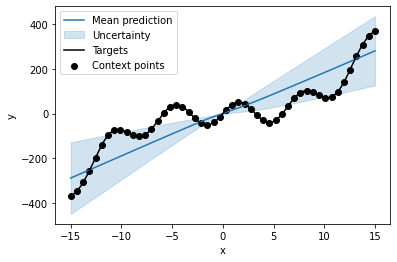

In [123]:
N_EPOCHS = 200

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neural_process.parameters(), lr=0.001)

for epoch in range(N_EPOCHS):
    
    rmse_vals = []
    
    for context_x, context_y, target_x, target_y in train_dataloader:
        
        encoder_input = torch.cat([context_x, context_y], axis=2)

        output_distribution = neural_process(encoder_input, target_x)
        
        loss = torch.mean(-output_distribution.log_prob(target_y)) #criterion(target_y, prediction)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        rmse_vals.append(loss.item())
        
    clear_output(wait=True)
    print(f"Epoch {epoch+1} RMSE: {np.mean(rmse_vals)}")
    plot_prediction(N_TARGET_POINTS, N_CONTEXT)

In [94]:
N_TARGET_POINTS = 100
N_CONTEXT = 50
    
plot_prediction(N_TARGET_POINTS, N_CONTEXT)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

### MNIST

In [46]:
import itertools
import os

import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [55]:
mnist = torchvision.datasets.MNIST(root="", download=True,
                                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

if os.path.exists("X.npy") is False:

    X = []
    Y = []

    for (image, label) in tqdm(mnist):

        idx = np.arange(0, 28).astype(np.int32)
        idx_2d = list(itertools.product(idx, idx))
        y = [image[0, x[0], x[1]].float().detach().cpu().numpy().astype(np.float32) for x in idx_2d]

        X.append(np.array(idx_2d))
        Y.append(np.array(y))

    del mnist
    np.save("X.npy", np.array(X))
    np.save("Y.npy", np.array(Y))

else:
    X = np.load("X.npy", allow_pickle=True)
    Y = np.load("Y.npy", allow_pickle=True)

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [09:52<00:00, 101.26it/s]


In [103]:
class MNISTData(Dataset):
    
    def __init__(self, X, Y, context_sample_range, target_sample_range):
        super().__init__()
        
        self.X = X
        self.Y = Y
        self.context_sample_range = context_sample_range
        self.target_sample_range = target_sample_range
        
        assert np.max([self.context_sample_range, self.target_sample_range]) <= 28*28
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        
        n_context_points = np.random.randint(*self.context_sample_range)
        n_target_points = np.random.randint(*self.target_sample_range)
        
        context_x, context_y, target_x, target_y = self._get_subset(idx, n_context_points, n_target_points)
        
        return context_x, context_y, target_x, target_y
    
    def _get_subset(self, idx, n_context_points, n_target_points):
        
        sample_x = self.X[idx]
        sample_y = self.Y[idx]
        
        context_idxs = np.random.choice(np.arange(0, len(sample_x)), n_context_points, replace=False)
        target_idxs = np.random.choice(np.arange(0, len(sample_x)), n_target_points, replace=False)
        
        context_x = np.array(sample_x[context_idxs])/28
        context_y = np.array(sample_y)[context_idxs].reshape(-1, 1)
        
        target_x = np.array(sample_x)[target_idxs]/28
        target_y = np.array(sample_y)[target_idxs].reshape(-1, 1)
        
        return context_x, context_y, target_x, target_y

In [104]:
train_X = X[0:40_000]
train_Y = Y[0:40_000]

val_X = X[40_000:50_000]
val_Y = Y[40_000:50_000]

test_X = X[50_000:]
test_Y = Y[50_000:]

train_dataset = MNISTData(train_X, train_Y, (5, 50), (5, 28*28))
val_dataset = MNISTData(val_X, val_Y, (5, 50), (5, 28*28))
test_dataset = MNISTData(test_X, test_Y, (5, 50), (5, 28*28))

train_dataloader = DataLoader(train_dataset)
val_dataloader = DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

In [105]:
LATENT_DIM = 128
N_HIDDEN = 128*4
N_INPUT = 2
N_OUTPUT = 1

encoder = Encoder(N_INPUT+1, N_HIDDEN, LATENT_DIM).cuda()
decoder = Decoder(LATENT_DIM, N_INPUT, N_OUTPUT, N_HIDDEN).cuda()
neural_process = NeuralProcess(encoder, decoder, LATENT_DIM).double().cuda()

In [108]:
N_EPOCHS = 200

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neural_process.parameters(), lr=0.001)

for epoch in range(N_EPOCHS):
    
    train_rmse_vals = []
    
    for context_x, context_y, target_x, target_y in tqdm(train_dataloader):
        
        encoder_input = torch.cat([context_x, context_y], axis=2)

        output_distribution = neural_process(encoder_input.cuda(), target_x.cuda())
        
        loss = torch.mean(-output_distribution.log_prob(target_y.cuda()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_rmse_vals.append(loss.item())
        
    val_rmse_vals = []
        
    for context_x, context_y, target_x, target_y in val_dataloader:
        
        encoder_input = torch.cat([context_x, context_y], axis=2)

        output_distribution = neural_process(encoder_input.cuda(), target_x.cuda())
        
        loss = torch.mean(-output_distribution.log_prob(target_y.cuda()))
        
        val_rmse_vals.append(loss.item())
        
    clear_output(wait=True)
    print(f"Epoch {epoch+1} train RMSE: {np.mean(train_rmse_vals)}, val RMSE: {np.mean(val_rmse_vals)}")
    plot_prediction(N_TARGET_POINTS, N_CONTEXT)

  0%|▏                                                                             | 120/40000 [00:04<24:49, 26.77it/s]


KeyboardInterrupt: 

In [ ]:
def plot_image_prediction(n_target_points, n_context):

    pred_x, pred_y = gen_data(n_target_points, ordered=True)
    context_x, context_y = gen_data(n_context)
    encoder_input = torch.cat([torch.Tensor(context_x.reshape(1, n_context, N_OUTPUT)), 
                               torch.Tensor(context_y.reshape(1, n_context, N_OUTPUT))], axis=2)

    prediction_distribution = neural_process(encoder_input[:1,:,:].double(), 
                                             torch.Tensor(pred_x.reshape(1, n_target_points, N_OUTPUT)).double())

    prediction = prediction_distribution.mean

    prediction = prediction.reshape(-1).detach().cpu().numpy()

    uncertainty = prediction_distribution.stddev[0]
    uncertainty = uncertainty.reshape(-1).detach().cpu().numpy()

    plt.plot(pred_x.reshape(-1), prediction, color='tab:blue', label="Mean prediction")
    plt.fill_between(pred_x.reshape(-1), prediction - 1.97*uncertainty, prediction + 1.97*uncertainty, alpha=0.2, 
                     color='tab:blue', label="Uncertainty")
    plt.plot(x, y, color='black', label="Targets")
    plt.scatter(context_x.reshape(-1), context_y.reshape(-1), color='black', label="Context points")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [ ]:
N_TARGET_POINTS = 100
N_CONTEXT = 50
    
plot_prediction(N_TARGET_POINTS, N_CONTEXT)